# Задачи о рюкзаке

1. В рюкзак объема 7 кладут три группы предметов. Объем и вес каждого предмета указан в таблице: 

| № группы | 1 | 2 | 3 |
| --- | --- | --- | --- |
| Объем | 2 | 3 | 1 |
| Вес | 1 | 4 | 1 |

Максимизировать общий вес рюкзака

Задача будет решаться при помощи генетического алгоритма. Будем случайно генерировать вектора-родители, скрещивать их, с некоторой вероятностью вызывать мутацию и отбирать лучшие из дочерних векторов для того, чтобы они создавали следующее поколение.

In [3]:
import numpy as np
import random
import pandas as pd

class Backpack_solver: #Создаем класс, который будет содержать в себе методы генетического алгоритма
    def __init__(self, maximum_children, start_number_of_parents, table_volumes_weights, backpack_volume, breeding_coef):
        self.maximum_children = maximum_children
        self.start_number_of_parents = start_number_of_parents
        self.constraint = backpack_volume
        self.maximum_parent = backpack_volume / np.min(table_volumes_weights[0])
        self.breeding_coef = breeding_coef
        self.volumes_coefs = table_volumes_weights[0]
        self.weights_coefs = table_volumes_weights[1]
        

    def Backpack(self, items): #Функция которая возвращает вес и объём рюкзака
        x, y, z = items[0], items[1], items[2]
        a_v, b_v, c_v = self.volumes_coefs[0], self.volumes_coefs[1], self.volumes_coefs[2]
        a_w, b_w, c_w = self.weights_coefs[0], self.weights_coefs[1], self.weights_coefs[2]
        weight = a_w*x + b_w*y + c_w*z
        volume = a_v*x + b_v*y + c_v*z
        return(weight, volume)

    def Generator(self): #Функция которая возвращает список из "родителей"
        parents = list()
        for i in range(self.start_number_of_parents):
            parent = np.random.randint(low=0, high=self.maximum_parent, size=3)
            weight, volume = self.Backpack(parent)
            while volume > self.constraint:
                parent = np.random.randint(low=0, high=self.maximum_parent, size=3)
                weight, volume = self.Backpack(parent)
            parents.append(parent)
        return(parents)
    
    def Breeding(self, first_parent, second_parent): #Функция "размножения"
        def Crossover(first_parent, second_parent): #Функция-кроссовер для смешивания генов
            children = list()
            cross_slice = [1, 2]
            for elem in cross_slice:
                child1, child2 = np.append(first_parent[:elem], second_parent[elem:]), np.append(second_parent[:elem], first_parent[elem:])
                children.append(child1)
                children.append(child2)
            return(children)
        
        def Mutation(children): #Функция мутации одного из генов
            mutate_state = np.random.randint(low=0, high=2) #Мутация может произойти, а может и не произойти
            if mutate_state == 1: 
                i = np.random.randint(low=0, high=len(children))
                mut_ind = np.random.randint(low=0, high=len(children[i]))
                children[i][mut_ind] = children[i][mut_ind] + np.random.randint(low=0, high=3)
            return(children)

        def Selection(children): # Функция отбора дочерних векторов. Отбираются лишь те, которые удовлетворяют ограничению и самые "сильные" из оставшихся
            selected_children = list()
            for i in range(len(children)):
                weight, volume = self.Backpack(children[i])
                if volume <= self.constraint:
                    selected_children.append(children[i])   
            return(selected_children)

        #children = Selection(Mutation(Crossover(first_parent, second_parent)))
        children = Crossover(first_parent, second_parent)
        children = Mutation(children)
        children = Selection(children)

        childrens_selected = list()
        if len(children) >= self.maximum_children:
            for ch in range(self.maximum_children):
                max_weight = 0
                max_ind = 0
                for i in range(len(children)):
                    weight, volume = self.Backpack(children[i])
                    if weight > max_weight:
                        max_weight = weight
                        max_ind = i
                childrens_selected.append(children[max_ind])
                del children[max_ind]

        return(childrens_selected)
    
    def Evolution(self, parents): #Функция одного эволюционного цикла
        children = list()
        for epoch in range(int(len(parents) * self.breeding_coef)): # breeding_coef определяет, сколько процентов родителей будет давать потомство
            parent1, parent2 = random.choice(parents), random.choice(parents) # Родители выбираются случайным образом
            children.append(self.Breeding(parent1, parent2))
        return([item for sublist in children for item in sublist])

In [4]:
alg = Backpack_solver(2, 35, table, 7, 0.5) #Создаем экземпляр класса со следующими параметрами:
                                            #макс.потомков - 2, нач.кол-во родителей - 35
                                            #table - условие задачи, огранич. на объём - 7
                                            #коэфф.размножения - 0.5

evo_num = 60 #Количество эволюций
evo_epochs = 40 #Количество эволюционных эпох

keys = ['evolution', 'evolution_epoch', 'number_of_parents', 'number_of_children', 'best_child_weight', 'mean_children']
results = {key: [] for key in keys}

NameError: name 'table' is not defined

Для того, чтобы отслеживать деятельность модели, введем несколько показателей качества. Для каждой эпохи будем считать вес наилучшего потомка, а также средний вес по всем потомкам.
Для гарантированного результата запустим несколько эволюций с разными первыми поколениями.

In [185]:
solution_weigth = 0

for evo in range(evo_num):
    parents = alg.Generator() #Генерируем начальное поколение
    for epoch in range(evo_epochs):
        best_child_weight = 0
        sum_weights = 0
        children = alg.Evolution(parents)
        for child in children:
            weight, volume = alg.Backpack(child)
            sum_weights += weight
            if weight > best_child_weight:
                best_child_weight = weight
                best_child = child
        results['evolution'].append(evo)
        results['evolution_epoch'].append(epoch)
        results['number_of_parents'].append(len(parents))
        results['number_of_children'].append(len(children))
        results['best_child_weight'].append(best_child_weight)
        results['mean_children'].append(sum_weights/len(children))
        if best_child_weight > solution_weigth:
            solution_weigth = best_child_weight
            solution = best_child
        parents = children
    
results = pd.DataFrame(results)
print('Лучшее решение - ' + str(solution) + ', его вес - ' + str(solution_weigth))

Лучшее решение - [0 2 1], его вес - 9


Можно посмотреть на результаты работы алгоритма. Интересно будет взглянуть на то, как изменялось среднее значение веса для всех потомков(оно показывает, как точки сходятся в максимум).
Для первой эволюции например:

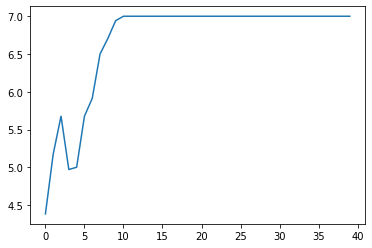

In [192]:
results[results.evolution == 0].mean_children.plot()

Нулевая эволюция сошлась в значении 7.

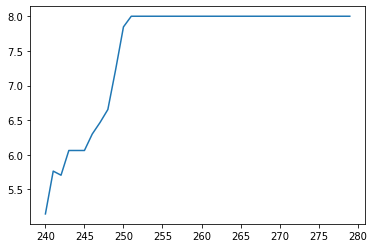

In [194]:
results[results.evolution == 6].mean_children.plot()

Шестая показывает результаты получше.

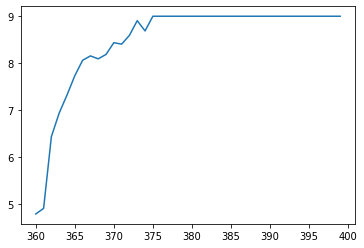

In [196]:
results[results.evolution == 9].mean_children.plot()

Девятая дала нам лучший результат.
Итак, ответ к первой задаче - 0, 2, 1, при этом вес рюкзака - 9.

2. В рюкзак объема 10 кладут три группы предметов. Объем и вес каждого предмета указан в таблице: 

| № группы | 1 | 2 | 3 |
| --- | --- | --- | --- |
| Объем | 3 | 2 | 1 |
| Вес | 1 | 3 | 2 |

Максимизировать общий вес рюкзака

In [5]:
table = np.array([[3, 2, 1], [1, 3, 2]])

alg = Backpack_solver(2, 35, table, 10, 0.5)

evo_num = 60 #Количество эволюций
evo_epochs = 40 #Количество эволюционных эпох

keys = ['evolution', 'evolution_epoch', 'number_of_parents', 'number_of_children', 'best_child_weight', 'mean_children']
results = {key: [] for key in keys}

solution_weigth = 0

for evo in range(evo_num):
    parents = alg.Generator() #Генерируем начальное поколение
    for epoch in range(evo_epochs):
        best_child_weight = 0
        sum_weights = 0
        children = alg.Evolution(parents)
        for child in children:
            weight, volume = alg.Backpack(child)
            sum_weights += weight
            if weight > best_child_weight:
                best_child_weight = weight
                best_child = child
        results['evolution'].append(evo)
        results['evolution_epoch'].append(epoch)
        results['number_of_parents'].append(len(parents))
        results['number_of_children'].append(len(children))
        results['best_child_weight'].append(best_child_weight)
        results['mean_children'].append(sum_weights/len(children))
        if best_child_weight > solution_weigth:
            solution_weigth = best_child_weight
            solution = best_child
        parents = children
    
results = pd.DataFrame(results)
print('Лучшее решение - ' + str(solution) + ', его вес - ' + str(solution_weigth))

Лучшее решение - [ 0  0 10], его вес - 20


3. В рюкзак объема 5 кладут три группы предметов. Объем и вес каждого предмета указан в таблице: 

| № группы | 1 | 2 | 3 |
| --- | --- | --- | --- |
| Объем | 2 | 3 | 1 |
| Вес | 3 | 7 | 2 |

Максимизировать общий вес рюкзака

In [204]:
table = np.array([[2, 3, 1], [3, 7, 2]])

alg = Backpack_solver(2, 35, table, 5, 0.5)
evo_num = 60 #Количество эволюций
evo_epochs = 40 #Количество эволюционных эпох

keys = ['evolution', 'evolution_epoch', 'number_of_parents', 'number_of_children', 'best_child_weight', 'mean_children']
results = {key: [] for key in keys}

solution_weigth = 0

for evo in range(evo_num):
    parents = alg.Generator() #Генерируем начальное поколение
    for epoch in range(evo_epochs):
        best_child_weight = 0
        sum_weights = 0
        children = alg.Evolution(parents)
        for child in children:
            weight, volume = alg.Backpack(child)
            sum_weights += weight
            if weight > best_child_weight:
                best_child_weight = weight
                best_child = child
        results['evolution'].append(evo)
        results['evolution_epoch'].append(epoch)
        results['number_of_parents'].append(len(parents))
        results['number_of_children'].append(len(children))
        results['best_child_weight'].append(best_child_weight)
        results['mean_children'].append(sum_weights/len(children))
        if best_child_weight > solution_weigth:
            solution_weigth = best_child_weight
            solution = best_child
        parents = children
    
results = pd.DataFrame(results)
print('Лучшее решение - ' + str(solution) + ', его вес - ' + str(solution_weigth))

Лучшее решение - [0 1 2], его вес - 11


4. В рюкзак объема 10 кладут три группы предметов. Объем и вес каждого предмета указан в таблице: 

| № группы | 1 | 2 | 3 |
| --- | --- | --- | --- |
| Объем | 2 | 3 | 4 |
| Вес | 2 | 3 | 5 |

Максимизировать общий вес рюкзака

In [205]:
table = np.array([[2, 3, 4], [2, 3, 5]])

alg = Backpack_solver(2, 35, table, 10, 0.5) 
evo_num = 100 #Количество эволюций
evo_epochs = 30 #Количество эволюционных эпох

keys = ['evolution', 'evolution_epoch', 'number_of_parents', 'number_of_children', 'best_child_weight', 'mean_children']
results = {key: [] for key in keys}

solution_weigth = 0

for evo in range(evo_num):
    parents = alg.Generator() #Генерируем начальное поколение
    for epoch in range(evo_epochs):
        best_child_weight = 0
        sum_weights = 0
        children = alg.Evolution(parents)
        for child in children:
            weight, volume = alg.Backpack(child)
            sum_weights += weight
            if weight > best_child_weight:
                best_child_weight = weight
                best_child = child
        results['evolution'].append(evo)
        results['evolution_epoch'].append(epoch)
        results['number_of_parents'].append(len(parents))
        results['number_of_children'].append(len(children))
        results['best_child_weight'].append(best_child_weight)
        results['mean_children'].append(sum_weights/len(children))
        if best_child_weight > solution_weigth:
            solution_weigth = best_child_weight
            solution = best_child
        parents = children
    
results = pd.DataFrame(results)
print('Лучшее решение - ' + str(solution) + ', его вес - ' + str(solution_weigth))

Лучшее решение - [1 0 2], его вес - 12


RK:


In [6]:
table = np.array([[2, 3, 1], [1, 4, 1]])

alg = Backpack_solver(2, 35, table, 7, 0.5)

evo_num = 60 #Количество эволюций
evo_epochs = 40 #Количество эволюционных эпох

keys = ['evolution', 'evolution_epoch', 'number_of_parents', 'number_of_children', 'best_child_weight', 'mean_children']
results = {key: [] for key in keys}

solution_weigth = 0

for evo in range(evo_num):
    parents = alg.Generator() #Генерируем начальное поколение
    for epoch in range(evo_epochs):
        best_child_weight = 0
        sum_weights = 0
        children = alg.Evolution(parents)
        for child in children:
            weight, volume = alg.Backpack(child)
            sum_weights += weight
            if weight > best_child_weight:
                best_child_weight = weight
                best_child = child
        results['evolution'].append(evo)
        results['evolution_epoch'].append(epoch)
        results['number_of_parents'].append(len(parents))
        results['number_of_children'].append(len(children))
        results['best_child_weight'].append(best_child_weight)
        results['mean_children'].append(sum_weights/len(children))
        if best_child_weight > solution_weigth:
            solution_weigth = best_child_weight
            solution = best_child
        parents = children
    
results = pd.DataFrame(results)
print('Лучшее решение - ' + str(solution) + ', его вес - ' + str(solution_weigth))

Лучшее решение - [0 2 1], его вес - 9
